In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.special import erf, erfc, ive, iv
from scipy.signal import find_peaks

from scipy.optimize import root,root_scalar

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [2]:
def SNR_regularized_delta_source(r,S0,n,lbda,KD,Rcell,epsilon=1):

    r[r==0] =  -1
    
    r_ep = r/(2*epsilon)**0.5
    s_ep = (epsilon/2/lbda**2)**0.5
    
    Erf1  = erf(r_ep-s_ep)
    Erfc2 = erfc(r_ep+s_ep)
    
    fr = 0.5*np.exp(s_ep**2) * (1+Erf1 - np.exp(2*r/lbda)*Erfc2)
    
    Cr = S0 * np.exp(-r/lbda)/r * fr
    
    fp_over_f= ( (8/np.pi/epsilon)**0.5 * np.exp(-(r_ep-s_ep)**2)
                 - 2/lbda * Erfc2*np.exp(2*r/lbda) ) \
                / ( 1 + Erf1 - Erfc2*np.exp(2*r/lbda) )
    
    p = 2*Rcell*np.abs(1/r+1/lbda-fp_over_f)
    
    Cr[r<0] = S0 * ((2/np.pi/epsilon)**0.5-np.exp(s_ep**2)*(1-erf(s_ep))/lbda)
    p[r<0] = 0
    sigma2_p = 8*(Cr + KD)**2/(n*Cr*KD)
    
    return p**2/sigma2_p, Cr


def SNR_regularized_delta_source_scalar(r,S0,n,lbda,KD,Rcell,epsilon=1):

    r_ep = r/(2*epsilon)**0.5
    s_ep = (epsilon/2/lbda**2)**0.5
    
    if r>0: 
        
        Erf1  = erf(r_ep-s_ep)
        Erfc2 = erfc(r_ep+s_ep)
        
        fr = 0.5*np.exp(s_ep**2) * (1+Erf1 - np.exp(2*r/lbda)*Erfc2)
        
        Cr = S0 * np.exp(-r/lbda)/r * fr
        
        fp_over_f= ( (8/np.pi/epsilon)**0.5 * np.exp(-(r_ep-s_ep)**2)
                     - 2/lbda * Erfc2*np.exp(2*r/lbda) ) \
                    / ( 1 + Erf1 - Erfc2*np.exp(2*r/lbda) )
        
        p = 2*Rcell*np.abs(1/r+1/lbda-fp_over_f)
    else:
        Cr = S0 * ((2/np.pi/epsilon)**0.5-np.exp(s_ep**2)*(1-erf(s_ep))/lbda)
        p = 0
    
    sigma2_p = 8*(Cr + KD)**2/(n*Cr*KD)
    
    return p**2/sigma2_p, Cr

def equipotency_vec(x,x0A,x0B,SA,SB,nA,nB,lbdaA,lbdaB,KDA,KDB,Rcell,epsilon=16):

    rA = ((x-x0A)**2)**0.5
    rB = ((x-x0B)**2)**0.5
    
    SNRA, CrA = SNR_regularized_delta_source(rA,SA,nA,lbdaA,KDA,Rcell,epsilon)
    SNRB, CrB = SNR_regularized_delta_source(rB,SB,nB,lbdaB,KDB,Rcell,epsilon)

    f = 0*SNRA
    x1 = np.where(x<x0A)
    x2 = np.where((x>=x0A) & (x<x0B))
    x3 = np.where(x>=x0B)
    f[x1] = SNRA[x1] + SNRB[x1]
    f[x2] = -SNRA[x2] + SNRB[x2]
    f[x3] = -SNRA[x3] - SNRB[x3]

    return f


def equipotency_2(x,x0A,x0B,SA,SB,nA,nB,lbdaA,lbdaB,KDA,KDB,Rcell,epsilon=16):


    rA = ((x-x0A)**2)**0.5
    rB = ((x-x0B)**2)**0.5
    
    SNRA,CrA = SNR_regularized_delta_source_scalar(rA,SA,nA,lbdaA,KDA,Rcell, epsilon=epsilon)
    SNRB,CrB = SNR_regularized_delta_source_scalar(rB,SB,nB,lbdaB,KDB,Rcell, epsilon=epsilon)

    if x<x0A:
        f=SNRA+SNRB
    elif x<x0B:
        f=-SNRA+SNRB
    else:
        f=-SNRA-SNRB
    
    return f

def find_root(x0A,x0B,SA,SB,nA,nB,lbdaA,lbdaB,KDA,KDB,Rcell):
    
    arg = (x0A,x0B,SA,SB,nA,nB,lbdaA,lbdaB,KDA,KDB,Rcell)
    bracket = (-10,10)
    aux=True
    i=1
    root_f=-500
    while aux:
        try:
            sol = root_scalar(equipotency_2, args=arg, method='bisect', bracket=bracket,rtol=1e-10)
            
            if sol.converged is True:
                
                root = sol.root
                root_p = equipotency_2(root+1,x0A,x0B,SA,SB,nA,nB,lbdaA,lbdaB,KDA,KDB,Rcell,epsilon=16)
                root_m = equipotency_2(root-1,x0A,x0B,SA,SB,nA,nB,lbdaA,lbdaB,KDA,KDB,Rcell,epsilon=16)
        
                if root_p-root_m<0:
                    return root
        except:
            pass
            
        i=i+1
        bracket = (-10*i,10*i)

        if i>20:
            aux=False

    return root_f


func = lambda x : (x-1)/x/(x+1) + (1 - K_*(x+2)*np.exp(x) )/( 1 + K_*x*np.exp(x) )

10000 10000 1.0 1.0


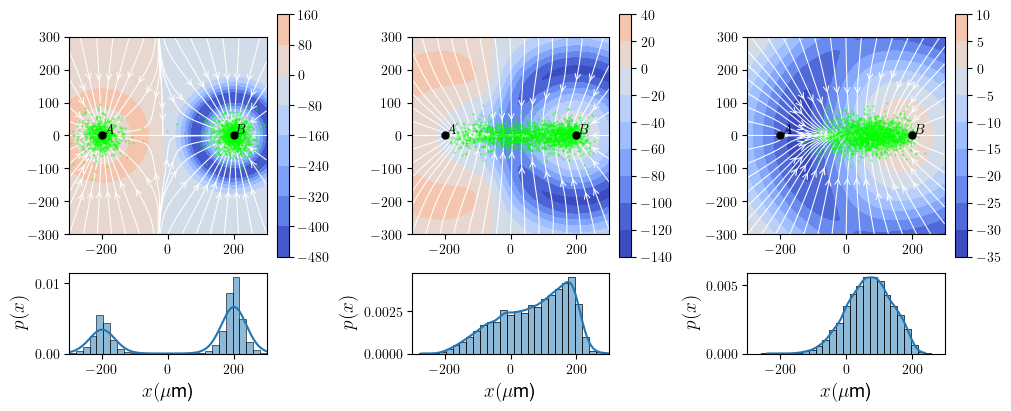

In [3]:
Rcell = 10

dt_r = 0.01
T = 1000.0
Ntraj = 10000

#cell
v0 = 5.0 # cell speed
Rcell = 10.0 # cell radius
Dtheta = 0.4 #0.01 # polarity noise
tau = 2.0 # relaxation rate
L0 = v0*tau

dt= tau*dt_r
nt = int(T/dt)
t = np.linspace(0,T,nt)


# Chemokine A
n = 10000 # number of type A receptors
KD = 1.0 # dissociation constant A
lbda = 50.0 # chemokine lengthscale A 0.05-0.1 nM/s
S0 = 12810.0 # source A size in units of gamma

epsilon=16

x0A,y0A = -200,0 #position source A
x0B,y0B = 200,0 #position source B

nA, KDA, lbdaA, SA = n, KD, lbda, S0
nB, KDB, lbdaB, SB = n, KD, lbda, S0


print(nA,nB,KDA,KDB)

fig, ax = plt.subplots(2,3,figsize=(10,4), width_ratios=[1,1,1], height_ratios=[3,1] ,layout='constrained' ) 


l= 0.2
nA = int(l*2*n)
nB = int(2*n-nA)

im=[]
vmax= -1e5
vmin = 1e5

lbda_vec = [25.0, 50.0, 100.0]
for i, lbda_i in enumerate(lbda_vec):

    lbdaA = lbda_i
    lbdaB = lbda_i

    lgrid = 300
    xgrid = np.linspace(-lgrid, lgrid,500)
    ygrid = np.linspace(-lgrid, lgrid,500)
    
    X, Y = np.meshgrid(xgrid, ygrid)
    rA = ((X-x0A)**2+(Y-y0A)**2)**0.5
    rB = ((X-x0B)**2+(Y-y0B)**2)**0.5
    
    phiA = np.arctan2(-(Y-y0A),-(X-x0A))
    phiB = np.arctan2(-(Y-y0B),-(X-x0B))

    
    SNRA, CrA = SNR_regularized_delta_source(rA,SA,nA,lbdaA,KDA,Rcell,epsilon)
    SNRB, CrB = SNR_regularized_delta_source(rB,SB,nB,lbdaB,KDB,Rcell,epsilon)
    
    wA = ive(1,SNRA)/ive(0,SNRA)
    wB = ive(1,SNRB)/ive(0,SNRB)
    
    clmap = 'coolwarm' # 'ReYlBu', 'RdBu', 'coolwarm', 'spectral', 'seismic'
    
    dAx = np.cos(phiA)*wA
    dAy = np.sin(phiA)*wA
    dBx = np.cos(phiB)*wB
    dBy = np.sin(phiB)*wB
    dmeanx = np.cos(phiA)*wA + np.cos(phiB)*wB
    dmeany = np.sin(phiA)*wA + np.sin(phiB)*wB

    # if np.max(SNRA-SNRB)>vmax:
    vmax = np.max(SNRA-SNRB)

    # if np.min(SNRA-SNRB)<vmin:
    vmin = np.min(SNRA-SNRB)
        
    ax[0,i].set_aspect('equal')
    im_i = ax[0,i].contourf(X, Y, SNRA-SNRB, cmap='coolwarm',zorder=1)
    im.append(im_i)
    ax[0,i].streamplot(X, Y, dmeanx, dmeany, density=0.5, linewidth=0.75, color='w', arrowstyle='->', arrowsize=1.0, broken_streamlines=False,zorder=2) 
    if np.abs(vmin)>vmax:
        im_i.set_clim(vmin=vmin,vmax=-vmin)
    else:
        im_i.set_clim(vmin=-vmax,vmax=vmax)
    fig.colorbar(im_i,ax=ax[0,i])

    dir = "./data/Anisotropic_sensing/"
    filename = 'N_{0}_v0_{1}_tau_{2}_Dth_{3}_nA_{4}_KDA_{5}_lbdaA_{6}_SA_{7}_nB_{8}_KDB_{9}_lbdaB_{10}_SB_{11}_T_{12}_dt_{13}'.format(Ntraj,v0,tau,Dtheta,nA,KDA,lbdaA,SA,nB,KDB,lbdaB,SB,T,dt_r)
    data = np.loadtxt(dir+"prw2grads_pos_ss_"+filename+".dat")
    x = data[:,0]
    y = data[:,1] 

    ax[0,i].scatter(x0A, y0A, marker='o',s=25,c='k',zorder=4)
    ax[0,i].scatter(x0B, y0B, marker='o',s=25,c='k',zorder=4)
    ax[0,i].text(x0A+5, y0A+5, '$A$',zorder=4)
    ax[0,i].text(x0B+5, y0B+5, '$B$',zorder=4)

    ax[0,i].set_xlim([-lgrid,lgrid])
    ax[0,i].set_ylim([-lgrid,lgrid])
    
    ax[0,i].scatter(x[::5],y[::5],marker='.',s=0.5,c='lime',zorder=3,alpha=0.8)
    
    bins = np.linspace(-300,300,30)
    sns.histplot(data=x, bins=bins, stat='density', kde=True, ax=ax[1,i])

    ax[1,i].set_xlim([-300,300])
    ax[1,i].set_xlabel('$x (\mu$m)', fontsize=14)
    ax[1,i].set_ylabel('$p(x)$', fontsize=14)


4000 16000


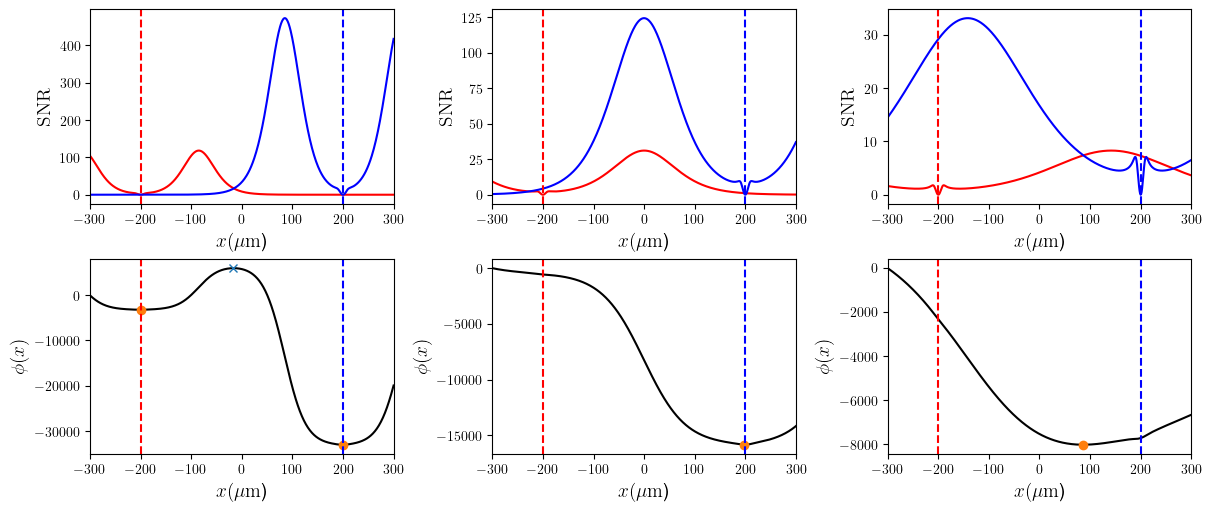

In [4]:

Rcell = 10

# Chemokine A
n = 10000 # number of type A receptors
KD = 1.0 # dissociation constant A
lbda = 100.0 # chemokine lengthscale A 0.05-0.1 nM/s
S0 = 12810.0 # source A size in units of gamma

epsilon=16

x0A,y0A = -200,0 #position source A
x0B,y0B = 200,0 #position source B

nA, KDA, lbdaA, SA = n, KD, lbda, S0
nB, KDB, lbdaB, SB = n, KD, lbda, S0


fig, ax = plt.subplots(2,3, figsize=(12,5),layout='constrained' ) 

l= 0.2
nA = int(l*2*n)
nB = int(2*n-nA)

print(nA,nB)

x = np.linspace(-300,300,600)
dx = x[1]-x[0]
rA = ((x-x0A)**2)**0.5
rB = ((x-x0B)**2)**0.5

lbda_vec = [25.0, 50, 100.0]
for i, lbda_i in enumerate(lbda_vec):

    lbdaA = lbda_i
    lbdaB = lbda_i

    SNRA, CrA = SNR_regularized_delta_source(rA,SA,nA,lbdaA,KDA,Rcell,epsilon=16)
    SNRB, CrB = SNR_regularized_delta_source(rB,SB,nB,lbdaB,KDB,Rcell,epsilon=16)

    ax[0,i].plot(x,SNRA, '-r')
    ax[0,i].plot(x,SNRB, '-b')
    
    
    f = equipotency_vec(x,x0A,x0B,SA,SB,nA,nB,lbdaA,lbdaB,KDA,KDB,Rcell,epsilon=16)

    phi = -np.cumsum(f)*dx

    xfpu, _ = find_peaks(phi**3, threshold=0.2)
    xfps, _ = find_peaks(-phi**3, threshold=0.2)
    
    ax[1,i].plot(x,phi, '-k')
    ax[1,i].plot(x[xfpu], phi[xfpu], "x")
    ax[1,i].plot(x[xfps], phi[xfps], "o")
    
    
    ax[0,i].axvline(x0A, ymin=0, ymax=1,ls='--',c='r')
    ax[0,i].axvline(x0B, ymin=0, ymax=1,ls='--',c='b')
    ax[0,i].set_xlim([-300,300])
    ax[0,i].set_xlabel('$x (\mu\mathrm{m}$)', fontsize=14)
    ax[0,i].set_ylabel('$\mathrm{SNR}$', fontsize=14)
    
    
    ax[1,i].axvline(x0A, ymin=0, ymax=1,ls='--',c='r')
    ax[1,i].axvline(x0B, ymin=0, ymax=1,ls='--',c='b')
    ax[1,i].set_xlim([-300,300])
    ax[1,i].set_xlabel('$x (\mu\mathrm{m}$)', fontsize=14)
    ax[1,i].set_ylabel('$\phi(x)$', fontsize=14)
    

Text(0, 0.5, '$x (\\mu\\mathrm{m})$')

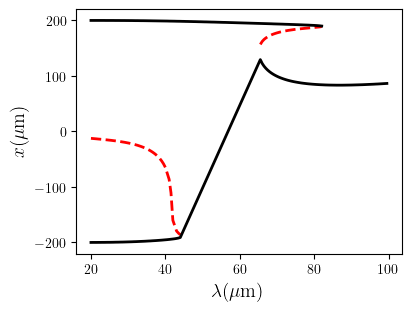

In [5]:

Rcell = 10

#cell
v0 = 5.0 # cell speed
Rcell = 10.0 # cell radius
Dtheta = 0.4 #0.01 # polarity noise
tau = 2.0 # relaxation rate
L0 = v0*tau

dt= tau*dt_r
nt = int(T/dt)
t = np.linspace(0,T,nt)


# Chemokine A
n = 10000 # number of type A receptors
KD = 1.0 # dissociation constant A
lbda = 50.0 # chemokine lengthscale A 0.05-0.1 nM/s
S0 = 12810.0 # source A size in units of gamma

epsilon=16

x0A,y0A = -200,0 #position source A
x0B,y0B = 200,0 #position source B

nA, KDA, lbdaA, SA = n, KD, lbda, S0
nB, KDB, lbdaB, SB = n, KD, lbda, S0


fig, ax = plt.subplots(figsize=(4,3),layout='constrained' ) 

l= 0.2
nA = int(l*2*n)
nB = int(2*n-nA)

x = np.linspace(-250,250,10000)
dx = x[1]-x[0]

lbda_vec = np.arange(20.0,100,0.5)

xpfu_v =[]
xpfs_v =[]

for i, lbda_i in enumerate(lbda_vec):

    lbdaA = lbda_i
    lbdaB = lbda_i

    f = equipotency_vec(x,x0A,x0B,SA,SB,nA,nB,lbdaA,lbdaB,KDA,KDB,Rcell,epsilon=16)

    phi = -np.cumsum(f)*dx

    xfpu, _ = find_peaks(phi**3, threshold=0.2)
    xfps, _ = find_peaks(-phi**3, threshold=0.2)

    # print(xfpu[0])

    for xfpu_i in xfpu:
        xpfu_v.append([lbda_i,xfpu_i])

    for xfps_i in xfps:
        xpfs_v.append([lbda_i,xfps_i])

xpfu_v = np.array(xpfu_v)
xpfs_v = np.array(xpfs_v)

eps = 0.5
x_equi = 130

xu = xpfu_v[:,0]
yu = x[xpfu_v[:,1].astype(int)]

ax.plot(xu[yu-x_equi>eps],yu[yu-x_equi>eps], "--r",lw=2)
ax.plot(xu[yu-x_equi<-eps],yu[yu-x_equi<-eps], "--r",lw=2)
ax.plot(xu[(yu-x_equi)**2<eps**2],yu[(yu-x_equi)**2<eps**2], "--r",lw=2)

xs = xpfs_v[:,0]
ys = x[xpfs_v[:,1].astype(int)]

ax.plot(xs[ys-x_equi>eps],ys[ys-x_equi>eps], "-k",lw=2)
ax.plot(xs[ys-x_equi<-eps],ys[ys-x_equi<-eps], "-k",lw=2)
ax.plot(xs[(ys-x_equi)**2<eps**2],ys[(ys-x_equi)**2<eps**2], "-k",lw=2)


ax.set_xlabel('$\lambda (\mu\mathrm{m})$', fontsize=14)
ax.set_ylabel('$x (\mu\mathrm{m})$', fontsize=14)


10000 10000 1.0 1.0
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


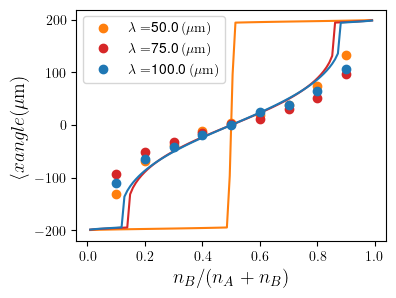

In [6]:

Rcell = 10

dt_r = 0.01
T = 1000.0
Ntraj = 1000

#cell
v0 = 5.0 # cell speed
Rcell = 10.0 # cell radius
Dtheta = 0.4 #0.01 # polarity noise
tau = 2.0 # relaxation rate
L0 = v0*tau

dt= tau*dt_r
nt = int(T/dt)
t = np.linspace(0,T,nt)


# Chemokine A
n = 10000 # number of type A receptors
KD = 1.0 # dissociation constant A
lbda = 100.0 # chemokine lengthscale A 0.05-0.1 nM/s
S0 = 12810.0 # source A size in units of gamma

epsilon=16

x0A,y0A = -200,0 #position source A
x0B,y0B = 200,0 #position source B

nA, KDA, lbdaA, SA = n, KD, lbda, S0
nB, KDB, lbdaB, SB = n, KD, lbda, S0

KDA = 1.0
KDB = 1/KDA

print(nA,nB,KDA,KDB)

fig, ax = plt.subplots(figsize=(4,3)) 

l_vec=np.linspace(0.01,0.99,100)

l_vec_sim = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
print(l_vec_sim)


lbda_vec = [50.0, 75.0,100.0]
color_vec = ['C1','C3','C0','C3','C4','C5']


for i,lbda in enumerate(lbda_vec):
    x_root =[]
    for l in l_vec:
        # l= l_vec[i]
        nB = int(l*2*n)
        nA = int(2*n-nB)
    
        KDA, lbdaA, SA = KD, lbda, S0
        KDB, lbdaB, SB = KD, lbda, S0

        x0=0
        arg = (x0A,x0B,SA,SB,nA,nB,lbdaA,lbdaB,KDA,KDB,Rcell)
        root = find_root(x0A,x0B,SA,SB,nA,nB,lbdaA,lbdaB,KDA,KDB,Rcell)
    
        x_root.append(root)
    
    nB = l_vec*2*n
    nA = 2*n-nB
    
    ax.plot(nB/(nA+nB),x_root,'-', c=color_vec[i])
    
    
    x_eq_sim =[]
    for l2 in l_vec_sim:
        nB = int(l2*2*n)
        nA = int(2*n-nB)
    
        KDA, lbdaA, SA = KD, lbda, S0
        KDB, lbdaB, SB = KD, lbda, S0

    
        dir = "./data/Anisotropic_sensing/"
        filename = 'N_{0}_v0_{1}_tau_{2}_Dth_{3}_nA_{4}_KDA_{5}_lbdaA_{6}_SA_{7}_nB_{8}_KDB_{9}_lbdaB_{10}_SB_{11}_T_{12}_dt_{13}'.format(Ntraj,v0,tau,Dtheta,nA,KDA,lbdaA,SA,nB,KDB,lbdaB,SB,T,dt_r)
        data = np.loadtxt(dir+"prw2grads_pos_ss_"+filename+".dat")
        x = data[:,0]
        y = data[:,1] 

        x_eq_sim.append(np.mean(x))
    
    
    nB = np.array(l_vec_sim)*2*n
    nA = 2*n-nB
    ax.plot(nB/(nA+nB),x_eq_sim,'o', c=color_vec[i], label=r'$\lambda = $'+str(lbda)+' $(\mu\mathrm{m})$')


ax.set_xlabel('$n_B/(n_A+n_B)$', fontsize=14)
ax.set_ylabel('$\langle x \rangle (\mu\mathrm{m})$', fontsize=14)
ax.legend(fontsize=10)
